# CE7454 Project - Group 01
# Sleep stages classification using EEG signals
### Emadeldeen Ahmed, Lotfi Ismail, Rakaraddi Appan

The link to our GitHub repository is [here](https://github.com/ismail0T/CE7454_project).


# Part I: Motivation
Sleep-wake classification is important for measuring the sleep quality as it significantly affects the quality of daily life and it helps in finding out sleep disorders. A lot of studies have been made in this field but most of them used hand-crafted features extraction which may lead to less accurate classification results and longer processing time. However, some new deep learning models can also be deployed to achieve better accuracy and faster results.

# Part II: Dataset Exploration
We will start by exploring and exploiting a public sleep EEG dataset, Physionet, which can be downloaded from [Physionet website](https://physionet.org/physiobank/database/sleep-edfx/). The dataset contains 78 whole-night PSG data and the corresponding hypnograms (sleep patterns).

PSG recordings include Electroencephalogram (EEG), Electrooculogram (EOG), Electromyogram (EMG) and Electrocardiogram (ECG) recordings [[1]](https://www.sciencedirect.com/science/article/pii/S0925231212008387). These PSG data can be classified as wake(W), Rapid Eye Movement (REM) sleep and Non-REM. Non-REM sleep is further divided into stages 1, 2, 3 and 4 [[2]](https://www.ncbi.nlm.nih.gov/pubmed/25629798). As indicated in the literature, the EEG are the most important and frequently used signals for analyzing sleep staging and many researches uses single-channel EEG to help reducing the sleep disturbances caused by PSG recording equipment.
In this analysis, we will explore using the same channel mentioned in the literature as well as using another channel besides. 
Note that we have tried using EOG recordings instead of EEG but didn't achieve better results.

In [1]:
import os
import random
import warnings
warnings.filterwarnings('ignore')
import datetime
import ntpath
from itertools import chain, repeat
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import mne
from mne.io import read_raw_edf
from mne import viz

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from Utils import *
from NN_Utils import *

In [2]:
data_path = '/home/ismail/Dev/data_2013'
channel_name = "\'EEG Fpz-Cz'"
data_dir_eeg = os.path.join(data_path, channel_name.replace("'", "").replace(" ", "_"))
sampling_mode = 'smote'  # smote or rus



#### Download Data


In [ ]:
f = open('preprocessing/download_physionet_13.sh', 'r')
save_path = "/home/ismail/Dev/data_2013"
if not os.path.exists(save_path):
    os.makedirs(save_path)
lines = f.read()

for url in lines.split('\n'):
    file_name = url.split("/")[-1]
    file_save_path = os.path.join(save_path, file_name)
    urllib.request.urlretrieve(url,file_save_path)
print("Dataset is download successfully !!!")

In [10]:
ann2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}
# Label values
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4
UNKNOWN = 5

sampling_rate = 100.0
EPOCH_SEC_SIZE = 30

Then we grap the edf files and hypnogram files to do some data analysis

In [11]:



# single subject
data_files = os.listdir(data_path)

edf_data_files = [i for i in data_files if "-PSG" in i]
hyp_data_files = [i for i in data_files if "Hypnogram" in i]

edf_files_path = os.path.join(data_path, edf_data_files[10])
hyp_files_path = os.path.join(data_path, hyp_data_files[10])

print(f"Number of PSG files used in analysis:       {len(edf_data_files)} files")
print(f"Number of hypnogram files used in analysis: {len(hyp_data_files)} files")

Number of PSG files used in analysis:       39 files
Number of hypnogram files used in analysis: 39 files


###### Counting the number of samples per each class
The Hypnogram files contains details about the duration and start time of the occurrence of each class, so will depend on it to count the total number of samples per class (in the whole files)

In [13]:
class_duration = {0:0,1:0,2:0,3:0,4:0}

for i in range(len(edf_data_files)):
#     psg_files_path = os.path.join(data_path, edf_data_files[i])
    hyp_files_path = os.path.join(data_path, hyp_data_files[i])
    
    # Read annotation and its header
    f = open(hyp_files_path, 'r', errors='ignore')
    reader_ann = BaseEDFReader(f)
    reader_ann.read_header()
    h_ann = reader_ann.header
    _, _, ann = zip(*reader_ann.records())
    f.close()
    ann_start_dt = datetime.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")

    file_duration_in_sec = ann[0][len(ann[0])-1][0] + ann[0][len(ann[0])-1][1]
    
    # Generate label and remove indices
    count = 0
    for a in ann[0]:
        onset_sec, duration_sec, ann_char = a
        ann_str = ann_char[0][2:-1]
        label = ann2label[ann_str]
        if label != UNKNOWN:
            if duration_sec % EPOCH_SEC_SIZE != 0:
                raise Exception("Something wrong")
            class_duration[label] += duration_sec
            count+=1


plotting these results ...

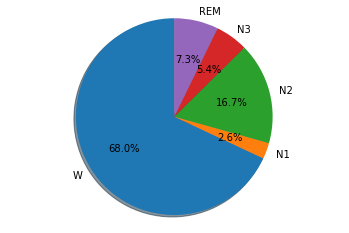

In [20]:
labels = ["W","N1","N2","N3","REM"]
fig1, ax1 = plt.subplots()
ax1.pie(list(class_duration.values()), labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

The plots shows that the wake class is the majority class in the dataset, with a big difference from the other 4 classes.
This will cause an imbalance in the dataset which will require doing either oversampling or undersampling.

##### plotting the data channels
For this section, we pick a random file and plot the data in the seven channels.

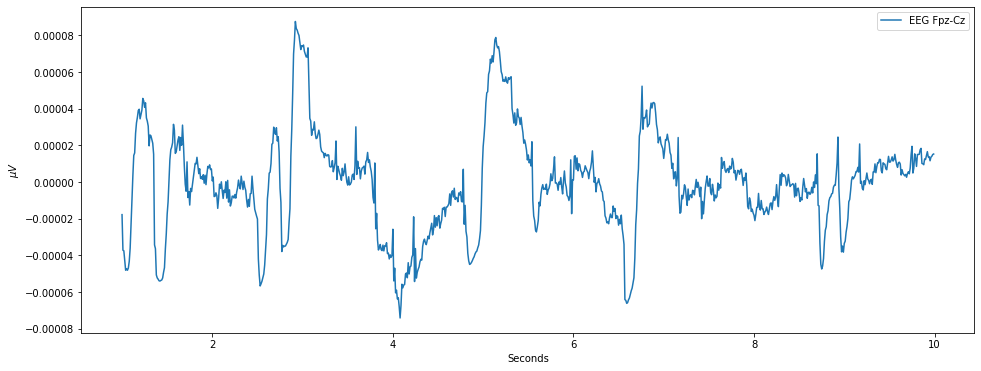

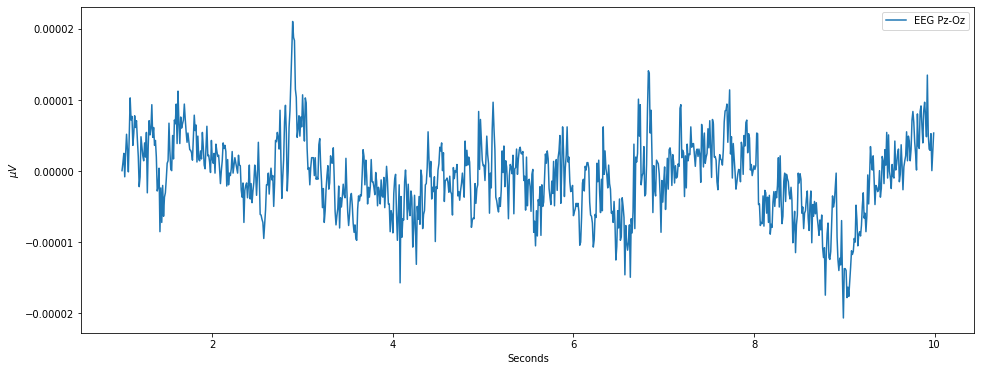

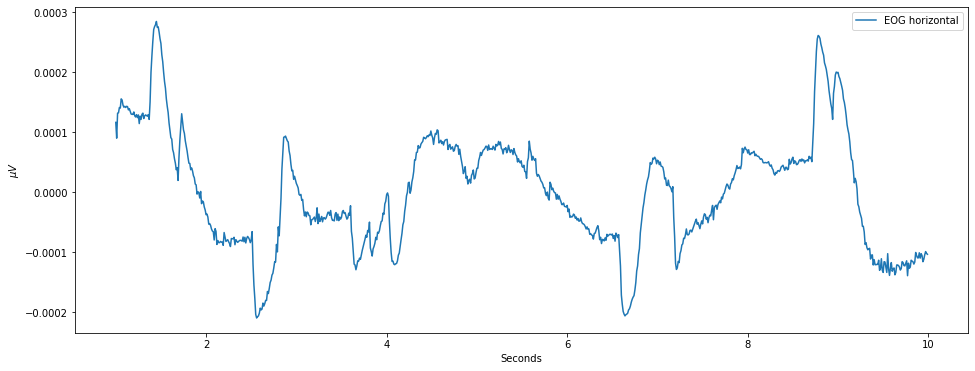

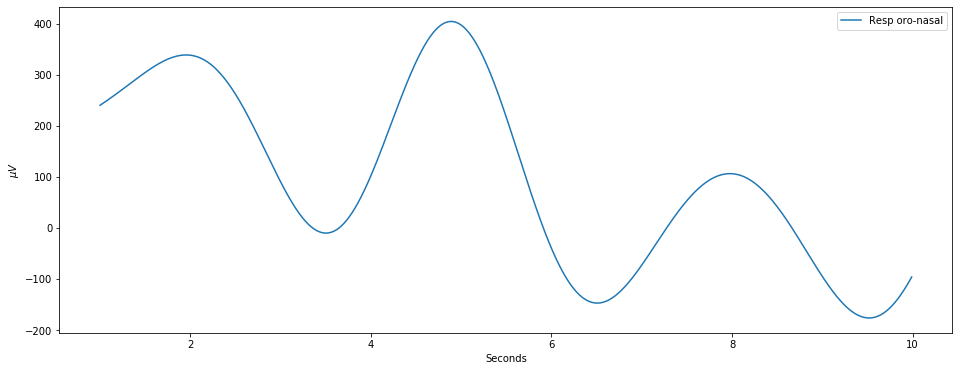

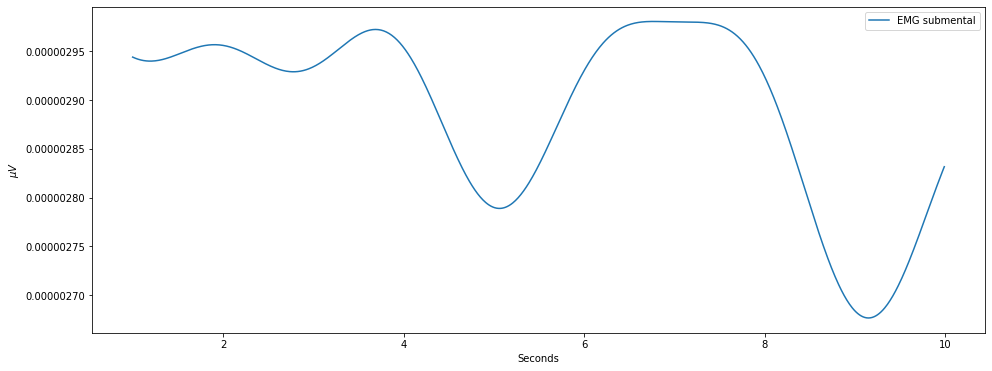

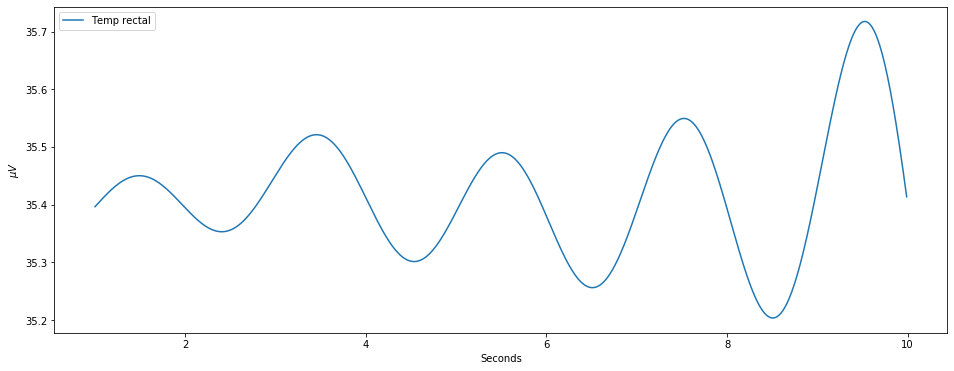

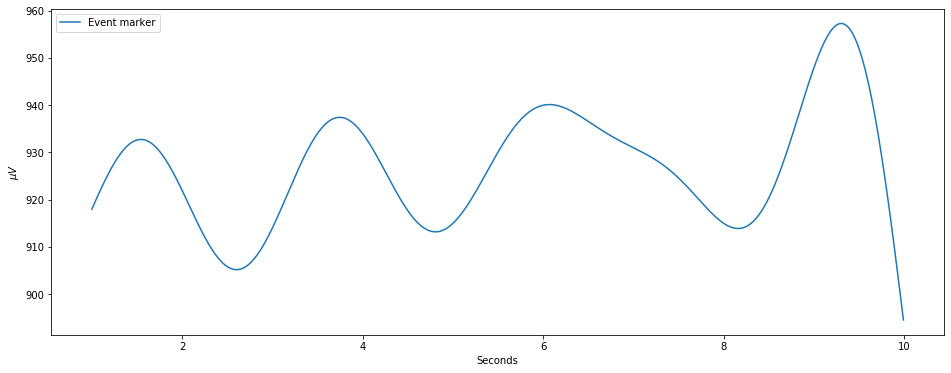

In [16]:
raw = read_raw_edf(edf_files_path, preload=True, stim_channel=None, verbose=False)

# Extract data from the first 5 channels, from 1 s to 3 s.
sfreq = raw.info['sfreq']

data = {}
times = {}
ch_names = {}
for ch in range(len(raw.info["chs"])): # 7 channels
    ch_names[ch] = raw.info["chs"][ch]['ch_name']
    data[ch], times[ch] = raw[ch, int(sfreq * 1):int(sfreq * 10)]

data_1, times_1 = raw[1, int(sfreq * 1):int(sfreq * 10)]

for i in range(len(raw.info["chs"])):
    fig = plt.subplots(figsize=(16,6))
    plt.plot(times[i], data[i].T)
    plt.xlabel('Seconds')
    plt.ylabel('$\mu V$')
    plt.legend([ch_names[i]])
    plt.show()




From the figures we can see that both the EEG Fpz-Cz channel and EOG channel are the most suitable channels for the analysis as 
they both share:
- They are not very noisy (compared to EEG Pz-Oz) channel,
- They are not too soft like the other last 3 channels

So we will follow most of the literature by starting with using EEG Fpz-Cz channel data, then we would add the other channel in the analysis.

# Part III: Dataset Preprocessing


The preprocessing of the EEG data passes through the following steps:
- Reading the EDF and hypnogram data files
- Extract information from edf files such as sampling rate, and starting time.
- Read start and end of each class from the hypnogram and generate labels and removing UNKOWN data classes.
- Check the length of the data and if it can be splitted into 30 seconds.
- Convert the EDF files accordingly to numpy files (npz)

<img src="preprocessing/preprocessing_1.png">

In [7]:
%run -i 'preprocessing/prepare_physionet.py' --data_dir $data_path --output_dir $data_dir_eeg --select_ch $channel_name

Extracting EDF parameters from /home/ismail/Dev/data_2013/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Converting "time" to "<class 'numpy.int64'>"...
Include onset:0.0, duration:30630.0, label:0 (b'Sleep stage W')
Include onset:30630.0, duration:120.0, label:1 (b'Sleep stage 1')
Include onset:30750.0, duration:390.0, label:2 (b'Sleep stage 2')
Include onset:31140.0, duration:30.0, label:3 (b'Sleep stage 3')
Include onset:31170.0, duration:30.0, label:2 (b'Sleep stage 2')
Include onset:31200.0, duration:150.0, label:3 (b'Sleep stage 3')
Include onset:31350.0, duration:30.0, label:3 (b'Sleep stage 4')
Include onset:31380.0, duration:60.0, label:3 (b'Sleep stage 3')
Include onset:31440.0, duration:60.0, label:3 (b'Sleep stage 4')
Include onset:31500.0, duration:30.0, label:3 (b'Sleep stage 3')
Include onset:31530.0, duration:120.0, label:3 (b'Sleep stage 4')
Include onset:3

after remove unwanted: (7950000,)
before intersect label: (7950000,)


KeyboardInterrupt: 

Next, the numpy files are read and concatenated together and the selection of how many files are used for training and testing is determined according to the required number of folds.

After that, we apply oversampling to the data using SMOTE algorithm.


In [14]:
%run -i 'preprocessing/concatenate_and_oversample.py' --data_dir $data_dir_eeg --sampling $sampling_mode

2019-11-10 22:40:17.534128

========== [Fold-0] ==========

Load training set:
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4101E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4042E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4122E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4011E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4052E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4081E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4031E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4111E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4062E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4182E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4162E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4002E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4022E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_Fpz-Cz/SC4172E0.npz ...
Loading /home/ismail/Dev/data_2013/EEG_

KeyboardInterrupt: 

# Part IV: Models
Since our dataset suffer from the imbalance problem, we will train our models on the data before and after oversampling.

In this project, there are 4 proposed models. Those are: basic ML, end-to-end CNN with dropout, end-to-end CNN with batch normalisation and CNN + LSTM. The following passages provides detailed explanation of each of those network structure.

## Model 1: Basic MLP
In this Multilayer perceptron structure, the network consists of 4 dense layers. The input dimension is defined in the first layer, that is, the dimention of 30-sec signal (3000 data point).

<img src="images/mlp.png">

In [3]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.n_classes = 5

        self.layer1 = nn.Linear(3000, 1024, bias=False)
        self.layer2 = nn.Linear(1024, 512, bias=False)
        self.layer3 = nn.Linear(512, 128, bias=False)
        self.layer4 = nn.Linear(128, self.n_classes, bias=False)

    def forward(self, x):
        x = x.reshape(x.size(0), x.size(1) * x.size(2))

        y = self.layer1(x)
        y = F.relu(y)
        
        y = self.layer2(y)
        y = F.relu(y)
        
        y = self.layer3(y)
        y = F.relu(y)

        scores = self.layer4(y)

        return  scores

## Model 2: end-to-end CNN with dropout
A 1D CNN is very effective in deriving important features from fixed-length segments of the overall data set and where the location of the feature within the segment is not of high relevance. Besides that, 1D-CNN can learn from raw time series data directly, and in turn do not require domain expertise to manually engineer input features. In our case we use 1D CNN by passing the data through different kernel sizes to get different types of features.

In this proposed CNN structure, the network consists of 8 layer: 6 convolutional layers folowed by 2 dense layers. The intermediate convolutional layers are interspersed by ReLU and average-pooling layers. A dropout layer is added after each two convolutional layer to help the network to generalize and reduce the gap between trainig and test accuracy/loss. 

<img src="images/conv1D0.png">

In [4]:
class ConvSimple(nn.Module):

    def __init__(self):
        super(ConvSimple, self).__init__()
        self.n_classes = 5
        self.conv1 = nn.Conv1d(1, 32, kernel_size=10, padding=1, stride=3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=10, padding=1, stride=3)
        self.pool1 = nn.AvgPool1d(2, stride=6)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool1d(2, stride=2)

        self.conv5 = nn.Conv1d(64, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.pool_avg = nn.AvgPool1d(2)

        self.linear1 = nn.Linear(3328, 128)

        self.dropout1 = nn.Dropout(0.2)

        # LL2:   128  -->  classes
        self.linear2 = nn.Linear(128, self.n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout1(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool_avg(x)
        x = self.dropout1(x)

        x = x.reshape(x.size(0), x.size(1) * x.size(2))

        x = self.linear1(x)
        x = F.relu(x)

        x = self.dropout1(x)

        x = self.linear2(x)

        return x

## Model 3: end-to-end CNN with batch normalization 
This CNN architecture is similar to the previous one (end-to-end CNN with dropout), however, instead of using dropout layers after convolutional layers, a batch normalization layer is used after each convolutional layer to speed up learning. Batch normalization reduces the amount by what the hidden unit values shift around.

We study the effect of using batch normalization instead of dropout layer and will make comparisons to see if it achieves better/worse performance.

<img src="images/ConvBatch_0.png">

In [5]:
class ConvBatchNorm(nn.Module):

    def __init__(self):
        super(ConvBatchNorm, self).__init__()
        self.n_classes = 5
        self.conv1 = nn.Conv1d(1, 32, kernel_size=10, padding=1, stride=3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=10, padding=1, stride=3)
        self.pool1 = nn.AvgPool1d(2, stride=6)
        self.bn1 = nn.BatchNorm1d(num_features=32)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool1d(2, stride=2)
        self.bn2 = nn.BatchNorm1d(num_features=64)

        self.conv5 = nn.Conv1d(64, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.pool_avg = nn.AvgPool1d(2)
        self.bn3 = nn.BatchNorm1d(num_features=256)


        self.linear1 = nn.Linear(3328, 128)

        self.dropout1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(128, self.n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool_avg(x)

        x = x.reshape(x.size(0), x.size(1) * x.size(2))

        x = self.linear1(x)
        x = F.relu(x)

        x = self.dropout1(x)

        x = self.linear2(x)

        return x


## Model 4: Conv + LSTM

Motivation:
- Before experimenting ConvLSTM, we tried LSTM alone and it suffered with long input sequence by taking a relatively longer time to train and did achieve poor classification accuracy. That's why it was important to reduce the length of the input sequence.
- It is also worth mentioning that 1D-CNN (alone) is unable to handle temporal dependancy as it does not have recurrent connection. 

These two problems motivated the use of ConvLSTM, which consists of stacking an LSTM layer after the CNN layers. In this architecture, the CNN is used for features extration and outputs a sequence of 128 features (and hence reduces input sequence size) and then fed to the LSTM layer for classification.

<img src="images/conv_lstm.png">

In [6]:
class ConvLSTM(nn.Module):

    def __init__(self, bi_dir=False):
        super(ConvLSTM, self).__init__()
        self.n_classes = 5
        self.hidden_dim = 256
        self.bi_dir = bi_dir

        # Conv
        self.conv1 = nn.Conv1d(1, 32, kernel_size=10, padding=1, stride=3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=10, padding=1, stride=3)
        self.pool1 = nn.MaxPool1d(2, stride=6)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(2, stride=2)


        self.linear1 = nn.Linear(1728, 128)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.6)


        # LSTM
        self.lstm_in_dim = 128
        self.lstm = nn.LSTM(self.lstm_in_dim, self.hidden_dim, bidirectional=self.bi_dir)

        # linear
        self.hidden2label1 = nn.Linear(self.hidden_dim * (1 + int(self.bi_dir)), self.n_classes)

    def forward(self, x, h_init, c_init):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout1(x)

        x = x.reshape(x.size(0), x.size(1) * x.size(2))

        x = self.linear1(x)
        x = F.relu(x)

        x = self.dropout1(x)

        cnn_x = F.relu(x)

        # LSTM
        g_seq = cnn_x.unsqueeze(dim=1)

        lstm_out, (h_final, c_final) = self.lstm(g_seq, (h_init, c_init))

        # Droput
        lstm_out = self.dropout2(lstm_out)

        # linear
        cnn_lstm_out = self.hidden2label1(lstm_out)

        # output
        scores = cnn_lstm_out

        return scores, h_final, c_final

In [7]:
# Global variables

classes = ['W', 'N1', 'N2', 'N3', 'REM']
n_classes = len(classes)
device = torch.device("cuda:1")
num_folds = 20
num_epochs = 25
do_balance=True

path_to_saved_models = "saved_models"
path_to_test_results = "test_results"

# Training and validation 

After discussing the models architectures, we now discuss the process of training and validation.
#### Data imbalance
As the dataset is not balanced, we studied 3 different cases:
- Applying the models to the dataset without sampling
- Applying under sampling technique (we used RandomUnderSampling)
- Applying over sampling technique (we used SMOTE)

#### Cross validation 
We split the dataset into 20 folds and we run the training for 19 folds and test on 1 fold. For each epoch, the average result of all the folds is reported.

<img src="images/cross_validation.png">

## Section A: No sampling

### 1. MLP

In [8]:
model = MLP()
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       3,072,000
            Linear-2                  [-1, 512]         524,288
            Linear-3                  [-1, 128]          65,536
            Linear-4                    [-1, 5]             640
Total params: 3,662,464
Trainable params: 3,662,464
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 13.97
Estimated Total Size (MB): 14.00
----------------------------------------------------------------


In [ ]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, do_balance=do_balance, sampling=0, do_print=False)
np.savez(os.path.join(path_to_test_results,"train_MLP"), train_history_over_CV)
np.savez(os.path.join(path_to_test_results,"val_MLP"), val_history_over_CV)

num_folds:  20  num_epochs:  25

Fold <1> 16:59:48
There are 3662464 (3.66 million) parameters in this neural network

Fold <2> 17:01:58

Fold <3> 17:03:56

Fold <4> 17:05:52

Fold <5> 17:07:43

Fold <6> 17:09:46

Fold <7> 17:11:41

Fold <8> 17:13:35

Fold <9> 17:15:29

Fold <10> 17:17:23

Fold <11> 17:19:10

Fold <12> 17:21:06


In [ ]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 2. Conv1D

In [9]:
model = ConvSimple()
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 998]             352
            Conv1d-2              [-1, 32, 331]          10,272
         AvgPool1d-3               [-1, 32, 55]               0
           Dropout-4               [-1, 32, 55]               0
            Conv1d-5               [-1, 64, 55]           6,208
            Conv1d-6               [-1, 64, 55]          12,352
         AvgPool1d-7               [-1, 64, 27]               0
           Dropout-8               [-1, 64, 27]               0
            Conv1d-9              [-1, 256, 27]          49,408
           Conv1d-10              [-1, 256, 27]         196,864
        AvgPool1d-11              [-1, 256, 13]               0
          Dropout-12              [-1, 256, 13]               0
           Linear-13                  [-1, 128]         426,112
          Dropout-14                  [

In [10]:
do_balance=True
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, do_balance=do_balance, sampling=0, do_print=False)
np.savez(os.path.join(path_to_test_results,"train_Conv"), train_history_over_CV)
np.savez(os.path.join(path_to_test_results,"val_Conv"), val_history_over_CV)

num_folds:  20  num_epochs:  25
Train Data Shape:  (40192, 1, 3000)   Test Data Shape:  (2048, 1, 3000)


__Train  W 7873  =>  345
__Train  N1 2704  =>  100
__Train  N2 16951  =>  848
__Train  N3 5407  =>  296
__Train  REM 7257  =>  459

Fold <1> 23:27:12
There are 702213 (0.70 million) parameters in this neural network
Epoch [1/25] , Accuracy :  41.93620621019109
Test Accuracy: 41.40625 %


Epoch [2/25] , Accuracy :  47.43730095541402
Test Accuracy: 54.39453125 %


Epoch [3/25] , Accuracy :  56.63813694267515
Test Accuracy: 57.32421875 %


Epoch [4/25] , Accuracy :  60.88525079617835
Test Accuracy: 56.8359375 %


Epoch [5/25] , Accuracy :  62.52985668789809
Test Accuracy: 61.71875 %


Epoch [6/25] , Accuracy :  66.06787420382165
Test Accuracy: 58.203125 %


Epoch [7/25] , Accuracy :  67.20740445859873
Test Accuracy: 64.208984375 %


Epoch [8/25] , Accuracy :  68.98636544585987
Test Accuracy: 59.86328125 %


Epoch [9/25] , Accuracy :  71.83519108280255
Test Accuracy: 68.5546875 %


Epo

Epoch [20/25] , Accuracy :  79.83678343949045
Test Accuracy: 78.125 %


Epoch [21/25] , Accuracy :  80.31449044585987
Test Accuracy: 78.41796875 %


Epoch [22/25] , Accuracy :  80.75985270700637
Test Accuracy: 78.515625 %


Epoch [23/25] , Accuracy :  81.25
Test Accuracy: 78.173828125 %


Epoch [24/25] , Accuracy :  81.58091162420382
Test Accuracy: 78.466796875 %


Epoch [25/25] , Accuracy :  82.03871417197452
Test Accuracy: 79.1015625 %


__Train  W 7904  =>  313
__Train  N1 2725  =>  79
__Train  N2 17221  =>  578
__Train  N3 5268  =>  435
__Train  REM 7330  =>  387

Fold <5> 23:36:23
Epoch [1/25] , Accuracy :  42.30369857594937
Test Accuracy: 32.254464285714285 %


Epoch [2/25] , Accuracy :  48.996242088607595
Test Accuracy: 38.22544642857143 %


Epoch [3/25] , Accuracy :  57.65674446202531
Test Accuracy: 46.484375 %


Epoch [4/25] , Accuracy :  62.10690268987342
Test Accuracy: 50.44642857142857 %


Epoch [5/25] , Accuracy :  67.31111550632912
Test Accuracy: 55.02232142857143 %


Epo

Epoch [14/25] , Accuracy :  78.60596498371335
Test Accuracy: 74.64488636363636 %


Epoch [15/25] , Accuracy :  78.82736156351791
Test Accuracy: 75.42613636363636 %


Epoch [16/25] , Accuracy :  79.3770358306189
Test Accuracy: 76.59801136363636 %


Epoch [17/25] , Accuracy :  79.7994706840391
Test Accuracy: 76.42045454545455 %


Epoch [18/25] , Accuracy :  80.12520358306189
Test Accuracy: 76.8465909090909 %


Epoch [19/25] , Accuracy :  80.59089983713355
Test Accuracy: 76.2784090909091 %


Epoch [20/25] , Accuracy :  80.87846091205212
Test Accuracy: 76.49147727272727 %


Epoch [21/25] , Accuracy :  81.15838762214985
Test Accuracy: 77.2372159090909 %


Epoch [22/25] , Accuracy :  81.48921009771986
Test Accuracy: 76.91761363636364 %


Epoch [23/25] , Accuracy :  81.64953175895765
Test Accuracy: 76.42045454545455 %


Epoch [24/25] , Accuracy :  82.12031758957656
Test Accuracy: 76.91761363636364 %


Epoch [25/25] , Accuracy :  82.34680374592834
Test Accuracy: 76.171875 %


__Train  W 7692  

Epoch [9/25] , Accuracy :  72.97371031746032
Test Accuracy: 68.64583333333333 %


Epoch [10/25] , Accuracy :  72.89682539682539
Test Accuracy: 67.23958333333333 %


Epoch [11/25] , Accuracy :  74.33531746031747
Test Accuracy: 69.32291666666667 %


Epoch [12/25] , Accuracy :  75.1016865079365
Test Accuracy: 68.75 %


Epoch [13/25] , Accuracy :  75.91765873015873
Test Accuracy: 71.77083333333333 %


Epoch [14/25] , Accuracy :  76.85019841269842
Test Accuracy: 69.32291666666667 %


Epoch [15/25] , Accuracy :  77.48015873015873
Test Accuracy: 70.88541666666667 %


Epoch [16/25] , Accuracy :  78.03075396825396
Test Accuracy: 70.78125 %


Epoch [17/25] , Accuracy :  78.66319444444444
Test Accuracy: 68.4375 %


Epoch [18/25] , Accuracy :  79.08482142857143
Test Accuracy: 68.64583333333333 %


Epoch [19/25] , Accuracy :  79.63045634920634
Test Accuracy: 66.40625 %


Epoch [20/25] , Accuracy :  80.03968253968254
Test Accuracy: 72.29166666666667 %


Epoch [21/25] , Accuracy :  80.48859126984127


Epoch [3/25] , Accuracy :  54.11492263843648
Test Accuracy: 66.30434782608695 %


Epoch [4/25] , Accuracy :  58.36471905537459
Test Accuracy: 70.65217391304348 %


Epoch [5/25] , Accuracy :  63.56626628664495
Test Accuracy: 74.66032608695652 %


Epoch [6/25] , Accuracy :  69.43963762214985
Test Accuracy: 76.3586956521739 %


Epoch [7/25] , Accuracy :  71.17263843648209
Test Accuracy: 77.07201086956522 %


Epoch [8/25] , Accuracy :  71.99206026058633
Test Accuracy: 77.9211956521739 %


Epoch [9/25] , Accuracy :  72.69187703583061
Test Accuracy: 80.36684782608695 %


Epoch [10/25] , Accuracy :  73.55710504885994
Test Accuracy: 79.24592391304348 %


Epoch [11/25] , Accuracy :  74.11441368078175
Test Accuracy: 79.4836956521739 %


Epoch [12/25] , Accuracy :  74.59792345276874
Test Accuracy: 79.78940217391305 %


Epoch [13/25] , Accuracy :  74.99745521172639
Test Accuracy: 78.19293478260869 %


Epoch [14/25] , Accuracy :  75.84995928338762
Test Accuracy: 78.15896739130434 %


Epoch [15/25] 

Epoch [24/25] , Accuracy :  82.98363095238095
Test Accuracy: 83.33333333333334 %


Epoch [25/25] , Accuracy :  83.68551587301587
Test Accuracy: 83.07291666666666 %


__Train  W 8101  =>  63
__Train  N1 2715  =>  85
__Train  N2 17394  =>  388
__Train  N3 5541  =>  162
__Train  REM 7465  =>  198

Fold <20> 00:10:43
Epoch [1/25] , Accuracy :  42.000679347826086
Test Accuracy: 43.30357142857143 %


Epoch [2/25] , Accuracy :  48.828125
Test Accuracy: 48.4375 %


Epoch [3/25] , Accuracy :  57.63295807453416
Test Accuracy: 64.62053571428571 %


Epoch [4/25] , Accuracy :  63.458365683229815
Test Accuracy: 64.50892857142857 %


Epoch [5/25] , Accuracy :  66.71195652173914
Test Accuracy: 66.51785714285714 %


Epoch [6/25] , Accuracy :  68.19681677018633
Test Accuracy: 66.29464285714286 %


Epoch [7/25] , Accuracy :  70.26640139751554
Test Accuracy: 67.52232142857143 %


Epoch [8/25] , Accuracy :  70.3610248447205
Test Accuracy: 65.51339285714286 %


Epoch [9/25] , Accuracy :  72.43546195652173
T

Epoch: 22  max_acc= 76.20354699754549


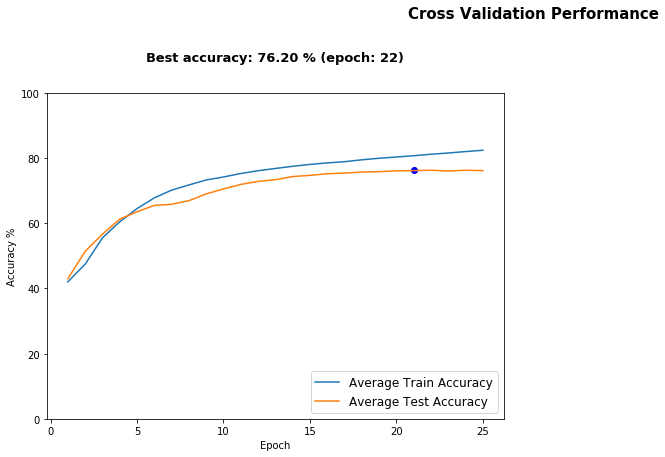

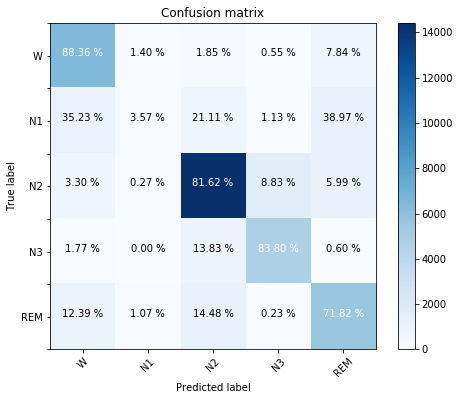

Acc  W 88.36 %
Acc  N1 3.57 %
Acc  N2 81.62 %
Acc  N3 83.80 %
Acc  REM 71.82 %


In [11]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 3. ConvBatchNorm

In [13]:
model = ConvBatchNorm()
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 998]             352
       BatchNorm1d-2              [-1, 32, 998]              64
            Conv1d-3              [-1, 32, 331]          10,272
       BatchNorm1d-4              [-1, 32, 331]              64
         AvgPool1d-5               [-1, 32, 55]               0
            Conv1d-6               [-1, 64, 55]           6,208
       BatchNorm1d-7               [-1, 64, 55]             128
            Conv1d-8               [-1, 64, 55]          12,352
       BatchNorm1d-9               [-1, 64, 55]             128
        AvgPool1d-10               [-1, 64, 27]               0
           Conv1d-11              [-1, 256, 27]          49,408
      BatchNorm1d-12              [-1, 256, 27]             512
           Conv1d-13              [-1, 256, 27]         196,864
      BatchNorm1d-14              [-1, 

In [14]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, do_balance=do_balance, sampling=0, do_print=False)
np.savez(os.path.join(path_to_test_results,"train_ConvBatchNorm"), train_history_over_CV)
np.savez(os.path.join(path_to_test_results,"val_ConvBatchNorm"), val_history_over_CV)

num_folds:  20  num_epochs:  25

Fold <1> 00:13:03
There are 702917 (0.70 million) parameters in this neural network

Fold <2> 00:15:29

Fold <3> 00:17:54

Fold <4> 00:20:20

Fold <5> 00:22:46

Fold <6> 00:25:12

Fold <7> 00:27:37

Fold <8> 00:30:02

Fold <9> 00:32:26

Fold <10> 00:34:50

Fold <11> 00:37:15

Fold <12> 00:39:41

Fold <13> 00:42:07

Fold <14> 00:44:33

Fold <15> 00:46:59

Fold <16> 00:49:23

Fold <17> 00:51:47

Fold <18> 00:54:13

Fold <19> 00:56:37

Fold <20> 00:59:03


Epoch: 19  max_acc= 75.89444231130581


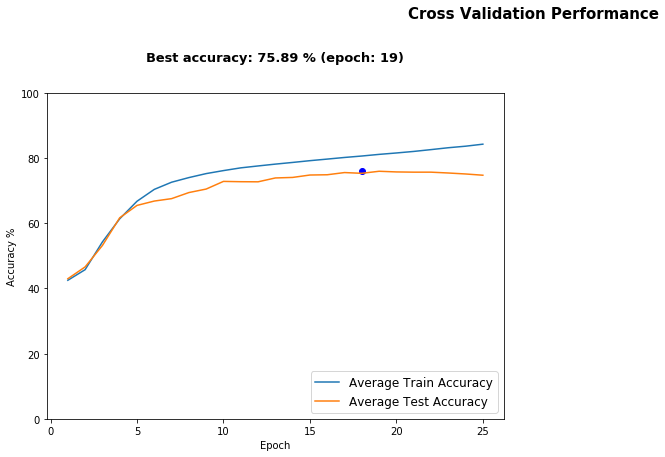

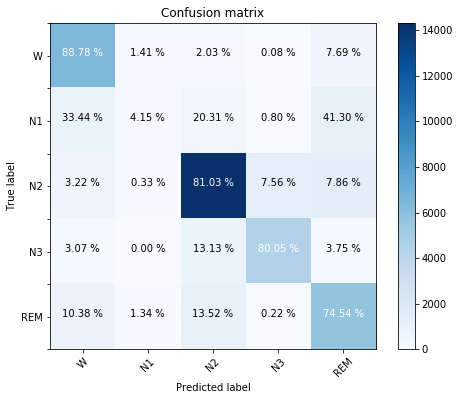

Acc  W 88.78 %
Acc  N1 4.15 %
Acc  N2 81.03 %
Acc  N3 80.05 %
Acc  REM 74.54 %


In [15]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 4. ConvLSTM

In [17]:
model = ConvLSTM()
batch_size = 64
learning_rate = 0.04

In [18]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, do_balance=do_balance, sampling=0, do_print=False)
np.savez(os.path.join(path_to_test_results,"train_ConvLSTM"), train_history_over_CV)
np.savez(os.path.join(path_to_test_results,"val_ConvLSTM"), val_history_over_CV)

num_folds:  20  num_epochs:  25

Fold <1> 01:01:31
There are 647045 (0.65 million) parameters in this neural network

Fold <2> 01:04:41

Fold <3> 01:07:51

Fold <4> 01:11:01

Fold <5> 01:14:11

Fold <6> 01:17:22

Fold <7> 01:20:31

Fold <8> 01:23:40

Fold <9> 01:26:47

Fold <10> 01:29:55

Fold <11> 01:33:05

Fold <12> 01:36:15

Fold <13> 01:39:25

Fold <14> 01:42:36

Fold <15> 01:45:46

Fold <16> 01:48:55

Fold <17> 01:52:02

Fold <18> 01:55:12

Fold <19> 01:58:21

Fold <20> 02:01:31


Epoch: 25  max_acc= 70.2558008792449


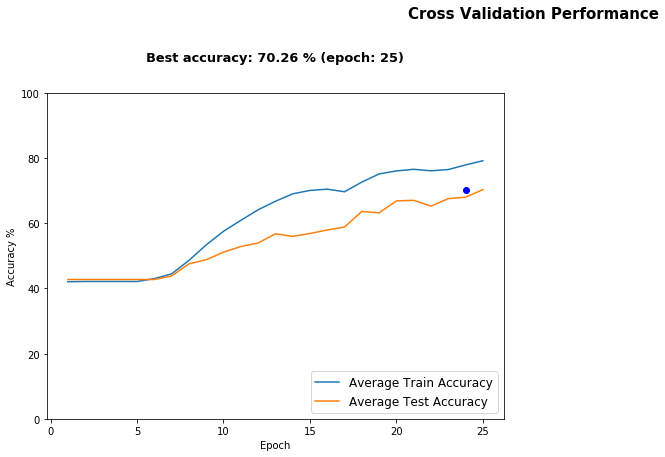

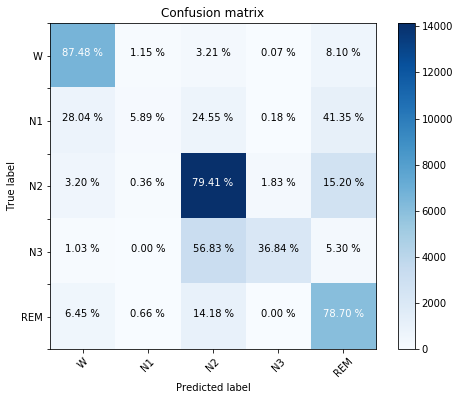

Acc  W 87.48 %
Acc  N1 5.89 %
Acc  N2 79.41 %
Acc  N3 36.84 %
Acc  REM 78.70 %


In [19]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

## Section B: After Under Sampling

In [23]:
# Data Folder
new_folder = "traindata_" + "rus"
data_dir_eeg_undersample = os.path.join(data_dir_eeg, new_folder)


### 1. MLP

In [24]:
model = MLP()
num_epochs =30
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         768,000
            Linear-2                    [-1, 5]           1,280
Total params: 769,280
Trainable params: 769,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 2.93
Estimated Total Size (MB): 2.95
----------------------------------------------------------------


In [25]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg_undersample, num_folds, num_epochs, learning_rate, batch_size, device, do_balance=do_balance, sampling=2, do_print=False)
np.savez(os.path.join(path_to_test_results,"train_MLP_under"), train_history_over_CV)
np.savez(os.path.join(path_to_test_results,"val_MLP_under"), val_history_over_CV)

num_folds:  20  num_epochs:  30

Fold <1> 12:31:18
There are 769280 (0.77 million) parameters in this neural network

Fold <2> 12:31:46

Fold <3> 12:32:13

Fold <4> 12:32:39

Fold <5> 12:33:05

Fold <6> 12:33:31

Fold <7> 12:33:56

Fold <8> 12:34:22

Fold <9> 12:34:47

Fold <10> 12:35:12

Fold <11> 12:35:36

Fold <12> 12:36:00

Fold <13> 12:36:24

Fold <14> 12:36:48

Fold <15> 12:37:12

Fold <16> 12:37:36

Fold <17> 12:38:01

Fold <18> 12:38:25

Fold <19> 12:38:49

Fold <20> 12:39:23


Epoch: 1  max_acc= 39.09086566890148


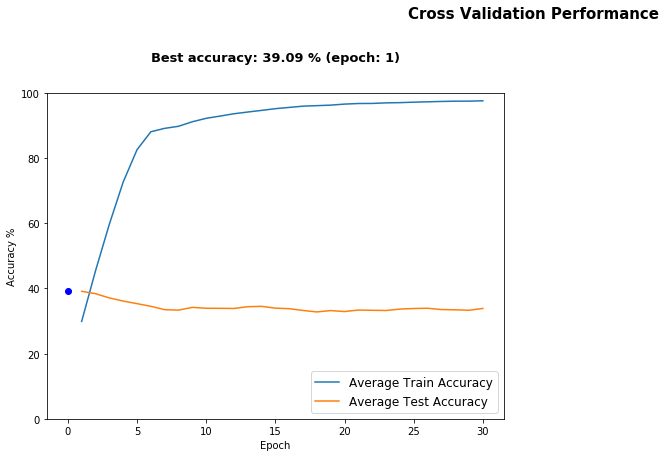

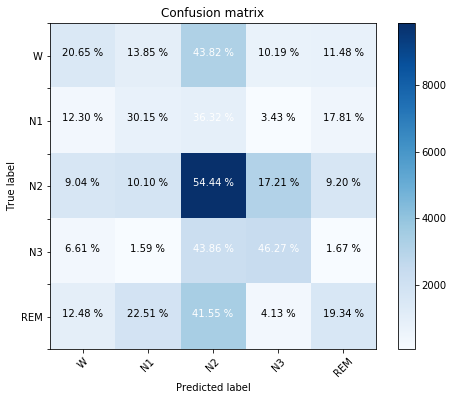

Acc  W 20.65 %
Acc  N1 30.15 %
Acc  N2 54.44 %
Acc  N3 46.27 %
Acc  REM 19.34 %


In [26]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 2. Conv1D

In [27]:
model = ConvSimple()
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 998]             352
            Conv1d-2              [-1, 32, 331]          10,272
         AvgPool1d-3               [-1, 32, 55]               0
           Dropout-4               [-1, 32, 55]               0
            Conv1d-5               [-1, 64, 55]           6,208
            Conv1d-6               [-1, 64, 55]          12,352
         AvgPool1d-7               [-1, 64, 27]               0
           Dropout-8               [-1, 64, 27]               0
            Conv1d-9              [-1, 256, 27]          49,408
           Conv1d-10              [-1, 256, 27]         196,864
        AvgPool1d-11              [-1, 256, 13]               0
          Dropout-12              [-1, 256, 13]               0
           Linear-13                  [-1, 128]         426,112
          Dropout-14                  [

In [28]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg_undersample, num_folds, num_epochs, learning_rate, batch_size, device, do_balance=do_balance, sampling=2, do_print=False)
np.savez(os.path.join(path_to_test_results,"train_Conv_under"), train_history_over_CV)
np.savez(os.path.join(path_to_test_results,"val_Conv_under"), val_history_over_CV)

num_folds:  20  num_epochs:  30

Fold <1> 12:39:47
There are 702213 (0.70 million) parameters in this neural network

Fold <2> 12:40:48

Fold <3> 12:41:46

Fold <4> 12:42:44

Fold <5> 12:43:42

Fold <6> 12:44:41

Fold <7> 12:45:38

Fold <8> 12:46:37

Fold <9> 12:47:36

Fold <10> 12:48:35

Fold <11> 12:49:32

Fold <12> 12:50:30

Fold <13> 12:51:26

Fold <14> 12:52:23

Fold <15> 12:53:21

Fold <16> 12:54:19

Fold <17> 12:55:17

Fold <18> 12:56:16

Fold <19> 12:57:13

Fold <20> 12:58:10


Epoch: 17  max_acc= 73.31648727170449


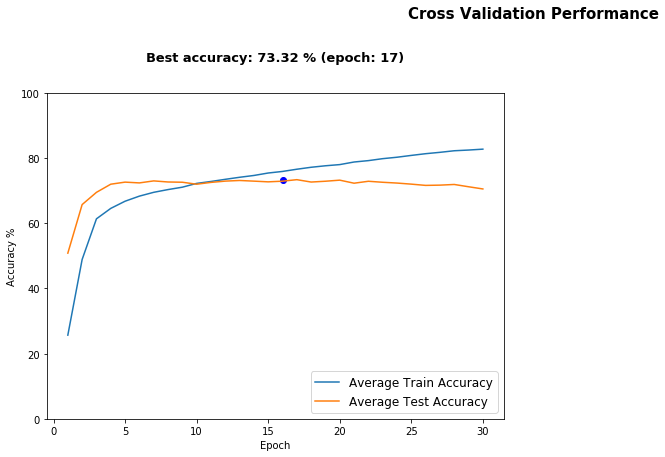

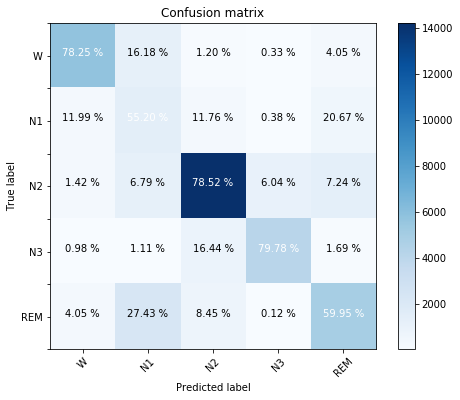

Acc  W 78.25 %
Acc  N1 55.20 %
Acc  N2 78.52 %
Acc  N3 79.78 %
Acc  REM 59.95 %


In [29]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 3. ConvBatchNorm

In [30]:
model = ConvBatchNorm()
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 998]             352
       BatchNorm1d-2              [-1, 32, 998]              64
            Conv1d-3              [-1, 32, 331]          10,272
       BatchNorm1d-4              [-1, 32, 331]              64
         AvgPool1d-5               [-1, 32, 55]               0
            Conv1d-6               [-1, 64, 55]           6,208
       BatchNorm1d-7               [-1, 64, 55]             128
            Conv1d-8               [-1, 64, 55]          12,352
       BatchNorm1d-9               [-1, 64, 55]             128
        AvgPool1d-10               [-1, 64, 27]               0
           Conv1d-11              [-1, 256, 27]          49,408
      BatchNorm1d-12              [-1, 256, 27]             512
           Conv1d-13              [-1, 256, 27]         196,864
      BatchNorm1d-14              [-1, 

In [31]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg_undersample, num_folds, num_epochs, learning_rate, batch_size, device, do_balance=do_balance, sampling=2, do_print=False)
np.savez(os.path.join(path_to_test_results,"train_ConvBatchNorm_under"), train_history_over_CV)
np.savez(os.path.join(path_to_test_results,"val_ConvBatchNorm_under"), val_history_over_CV)

num_folds:  20  num_epochs:  30

Fold <1> 12:59:08
There are 702917 (0.70 million) parameters in this neural network

Fold <2> 13:00:12

Fold <3> 13:01:14

Fold <4> 13:02:15

Fold <5> 13:03:17

Fold <6> 13:04:19

Fold <7> 13:05:21

Fold <8> 13:06:24

Fold <9> 13:07:27

Fold <10> 13:08:30

Fold <11> 13:09:32

Fold <12> 13:10:34

Fold <13> 13:11:35

Fold <14> 13:12:36

Fold <15> 13:13:39

Fold <16> 13:14:41

Fold <17> 13:15:44

Fold <18> 13:16:47

Fold <19> 13:17:49

Fold <20> 13:18:51


Epoch: 24  max_acc= 73.93127994779988


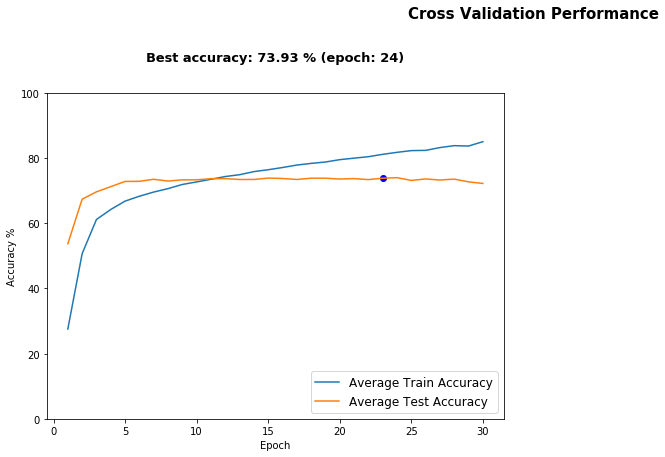

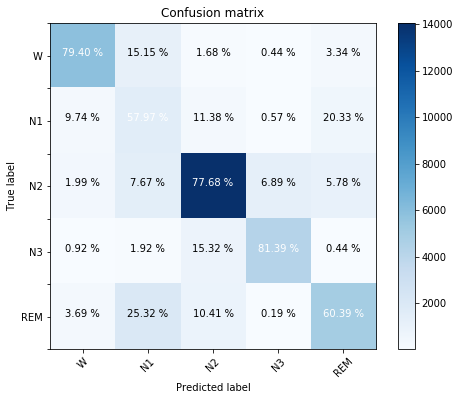

Acc  W 79.40 %
Acc  N1 57.97 %
Acc  N2 77.68 %
Acc  N3 81.39 %
Acc  REM 60.39 %


In [32]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 4. ConvLSTM

In [33]:
model = ConvLSTM()
batch_size = 64
learning_rate = 0.04

In [34]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg_undersample, num_folds, num_epochs, learning_rate, batch_size, device, do_balance=do_balance, sampling=2, do_print=False)
np.savez(os.path.join(path_to_test_results,"train_ConvLSTM_under"), train_history_over_CV)
np.savez(os.path.join(path_to_test_results,"val_ConvLSTM_under"), val_history_over_CV)

num_folds:  20  num_epochs:  30

Fold <1> 13:19:53
There are 647045 (0.65 million) parameters in this neural network

Fold <2> 13:21:17

Fold <3> 13:22:39

Fold <4> 13:23:59

Fold <5> 13:25:20

Fold <6> 13:26:42

Fold <7> 13:28:04

Fold <8> 13:29:27

Fold <9> 13:30:48

Fold <10> 13:32:11

Fold <11> 13:33:32

Fold <12> 13:34:52

Fold <13> 13:36:12

Fold <14> 13:37:32

Fold <15> 13:38:54

Fold <16> 13:40:14

Fold <17> 13:41:37

Fold <18> 13:42:59

Fold <19> 13:44:20

Fold <20> 13:45:41


Epoch: 29  max_acc= 48.045311875903714


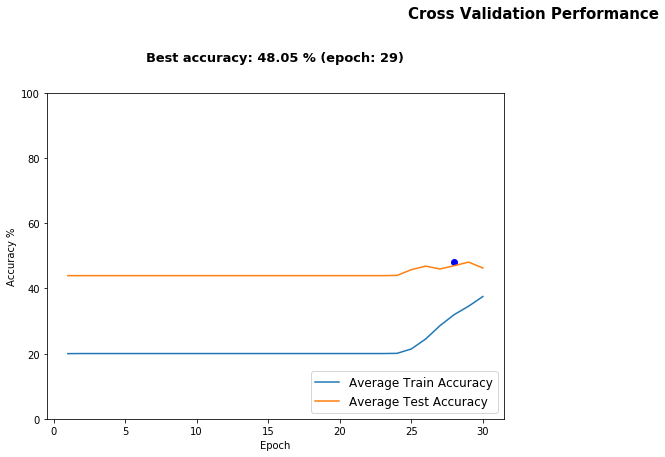

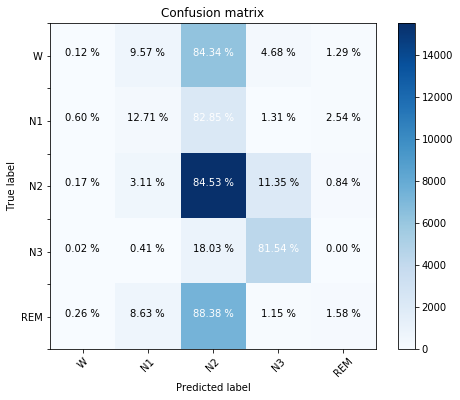

Acc  W 0.12 %
Acc  N1 12.71 %
Acc  N2 84.53 %
Acc  N3 81.54 %
Acc  REM 1.58 %


In [35]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

## Section C: After oversampling

In [13]:
# Data Folder
new_folder = "traindata_"+"smote"
data_dir_eeg_oversample = os.path.join(data_dir_eeg, new_folder)


### 1. MLP

In [14]:
model = MLP()
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         768,000
            Linear-2                    [-1, 5]           1,280
Total params: 769,280
Trainable params: 769,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 2.93
Estimated Total Size (MB): 2.95
----------------------------------------------------------------


In [15]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg_oversample, num_folds, num_epochs, learning_rate, batch_size, device, do_balance=do_balance, sampling=1, do_print=False)
np.savez(os.path.join(path_to_test_results,"train_MLP_smote"), train_history_over_CV)
np.savez(os.path.join(path_to_test_results,"val_MLP_smote"), val_history_over_CV)

num_folds:  20  num_epochs:  25


MemoryError: Unable to allocate array with shape (168945000,) and data type float32

In [ ]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 2. Conv1D

In [ ]:
model = ConvSimple()
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

In [ ]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg_oversample, num_folds, num_epochs, learning_rate, batch_size, device, do_balance=do_balance, sampling=1, do_print=False)
np.savez(os.path.join(path_to_test_results,"train_Conv_smote"), train_history_over_CV)
np.savez(os.path.join(path_to_test_results,"val_Conv_smote"), val_history_over_CV)

In [ ]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 3. ConvBatchNorm

In [ ]:
model = ConvBatchNorm()
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

In [ ]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg_oversample, num_folds, num_epochs, learning_rate, batch_size, device, do_balance=do_balance, sampling=1, do_print=False)
np.savez(os.path.join(path_to_test_results,"train_ConvBatchNorm_smote"), train_history_over_CV)
np.savez(os.path.join(path_to_test_results,"val_ConvBatchNorm_smote"), val_history_over_CV)

In [ ]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 4. ConvLSTM

In [ ]:
model = ConvLSTM()
batch_size = 64
learning_rate = 0.04

In [ ]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg_oversample, num_folds, num_epochs, learning_rate, batch_size, device, do_balance=do_balance, sampling=1, do_print=False)
np.savez(os.path.join(path_to_test_results,"train_ConvLSTM_smote"), train_history_over_CV)
np.savez(os.path.join(path_to_test_results,"val_ConvLSTM_smote"), val_history_over_CV)

In [ ]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)